## Project : Bayesian Inverse Reinforcement Learning

#### Importation des modules et packages nécessaires pour le projet

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import random

### Question 1

In [2]:
class PartialMDP:
    def __init__(self, states, actions, transition_probabilities, gamma=0.9):
        """
        Initializes a partially defined Markov Decision Process.
        
        Parameters:
        states (list): List of all possible states.
        actions (dict): Dictionary where keys are states and values are lists of possible actions from that state.
        transition_probabilities (dict): Nested dictionary where keys are (state, action) tuples and values are
                                         lists of (probability, next_state) tuples.
        gamma (float): Discount factor for future rewards.
        """
        self.states = states
        self.actions = actions
        self.transition_probabilities = transition_probabilities
        self.gamma = gamma

    def get_possible_actions(self, state):
        """
        Returns the list of possible actions from a given state.
        
        Parameters:
        state (any): The current state.
        
        Returns:
        list: Possible actions from the state.
        """
        return self.actions.get(state, [])

    def get_next_states(self, state, action):
        """
        Returns the list of possible next states and their probabilities given a state and action.
        
        Parameters:
        state (any): The current state.
        action (str): The action taken.
        
        Returns:
        list of tuples: Each tuple contains (probability, next_state).
        """
        return self.transition_probabilities.get((state, action), [])

### Questions 2 and 3

##### Gridworld setup

In [3]:
class GridWorld:
    def __init__(self, rows=8, columns=8, slip_probability=0.2, gamma=0.9):
        self.rows = rows
        self.columns = columns
        self.slip_probability = slip_probability
        self.gamma = gamma
        self.states = [(i, j) for i in range(1, columns+1) for j in range(1, rows+1)]
        self.actions = ['L', 'R', 'U', 'D']        
        # Transition probabilities will be a dictionary where the key is (state, action)
        # and the value is a list of (probability, state) pairs
        self.transition_probabilities = self.initialize_transitions()
        self.grid_visual = np.zeros((self.rows, self.columns))
        self.rewards = np.zeros((self.rows, self.columns))
        self.setup_features()

    def initialize_transitions(self):
        transitions = {}
        for state in self.states:
            transitions[state] = {}
            for action in self.actions:
                transitions[state][action] = self.calculate_transitions(state, action)
        return transitions

    def calculate_transitions(self, state, action):
        x, y = state
        next_state = self.move(x, y, action)
        slip_states = [self.move(x, y, a) for a in self.get_perpendicular_actions(action)]
        transitions = [(self.slip_probability / 2, slip) for slip in slip_states if slip != state]
        if next_state != state:
            transitions.append((1 - self.slip_probability, next_state))
        return transitions

    def move(self, x, y, action):
        if action == 'L' and y > 0:
            return (x, y-1)
        elif action == 'R' and y < self.columns-1:
            return (x, y+1)
        elif action == 'U' and x > 0:
            return (x-1, y)
        elif action == 'D' and x < self.rows-1:
            return (x+1, y)
        return (x,y)

    def get_perpendicular_actions(self, action):
        return ['U', 'D'] if action in ['L', 'R'] else ['L', 'R']
    
    def setup_features(self):
        # Define special states based on the image provided
        self.treasure_location = (7, 0)
        self.bomb_locations = [(2, 2), (3, 6), (6, 5)]
        self.mud_locations = [(0, 2), (0, 5), (1, 2), (1, 5), (6, 2), (6, 5), (7, 2), (7, 5)]
        self.water_locations = [(row, col) for row in range(1, 2) for col in range(0,2)]
        self.mountain_locations = [(row, col) for row in range(4, 5) for col in range(2, 4)]

        # Set rewards and transition probabilities for special features
        for state in self.states:
            x, y = state
            # Penalties
            if state in self.mud_locations:
                self.rewards[x][y] = -0.5  
            elif state in self.water_locations:
                self.rewards[x][y] = -1  
            elif state in self.mountain_locations:
                self.rewards[x][y] = -1  
            elif state in self.bomb_locations:
                self.rewards[x][y] = -10  
            elif state == self.treasure_location:
                self.rewards[x][y] = 10  
        
    def show_environment(self):
        # Visual representation for debugging
        env_visual = np.zeros((self.rows, self.columns))
        for x, y in self.mud_locations:
            env_visual[x][y] = 0.5  # Slightly different value for mud visualization
        for x, y in self.water_locations:
            env_visual[x][y] = 0.75  # Slightly different value for water visualization
        for x, y in self.mountain_locations:
            env_visual[x][y] = 1  # Slightly different value for mountain visualization
        for x, y in self.bomb_locations:
            env_visual[x][y] = -1  # Negative value for bombs
        env_visual[self.treasure_location] = 2  # Distinct value for treasure
        
        cmap = ListedColormap(sns.color_palette("coolwarm", n_colors=10).as_hex())
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(env_visual, cmap=cmap, annot=True, cbar=False,
                         linewidths=.5, square=True, fmt="",
                         xticklabels=list(range(1, 9)),
                         yticklabels=[chr(i) for i in range(ord('A'), ord('H') + 1)])
        ax = plt.gca()
        ax.invert_yaxis()
        plt.title('GridWorld MDP State Visualization')

        plt.show()

#### Instantiation

In [4]:
mdp = GridWorld()
state = (1, 1)
action = 'R'
print("Transition probabilities from (1,1) moving right:", mdp.transition_probabilities[state][action])

Transition probabilities from (1,1) moving right: [(0.1, (0, 1)), (0.1, (2, 1)), (0.8, (1, 2))]


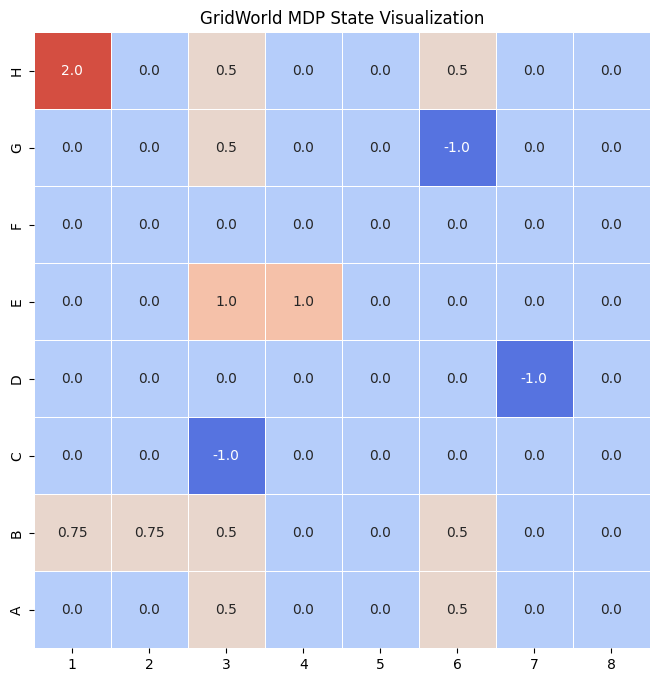

In [5]:
mdp.show_environment()

### Question 3

#### GridWorld generalization

In [6]:
class RandomGridWorld(GridWorld):
    def __init__(self, rows=8, columns=8, slip_probability=0.2, gamma=0.9, feature_counts=None):
        super().__init__(rows, columns, slip_probability, gamma)
        if feature_counts is None:
            feature_counts = {}
        self.features = ['Treasure', 'Bomb', 'Mud', 'Water', 'Mountain']
        self.grid_features = {state: [] for state in self.states}
        self.populate_features(feature_counts)

    def populate_features(self, feature_counts):
        """
        Randomly assign features to states based on provided counts for each feature.
        Ensure no feature overlaps unless allowed.
        """
        available_states = list(self.states)  # All states start as available
        for feature, count in feature_counts.items():
            if count > len(available_states):
                raise ValueError(f"Not enough available states to place {count} {feature}(s)")
            chosen_states = random.sample(available_states, count)
            for state in chosen_states:
                self.grid_features[state].append(feature)
                # Remove the state from available_states if features should not overlap
                available_states.remove(state)  # Ensure a state cannot be chosen again for another feature

#### Test

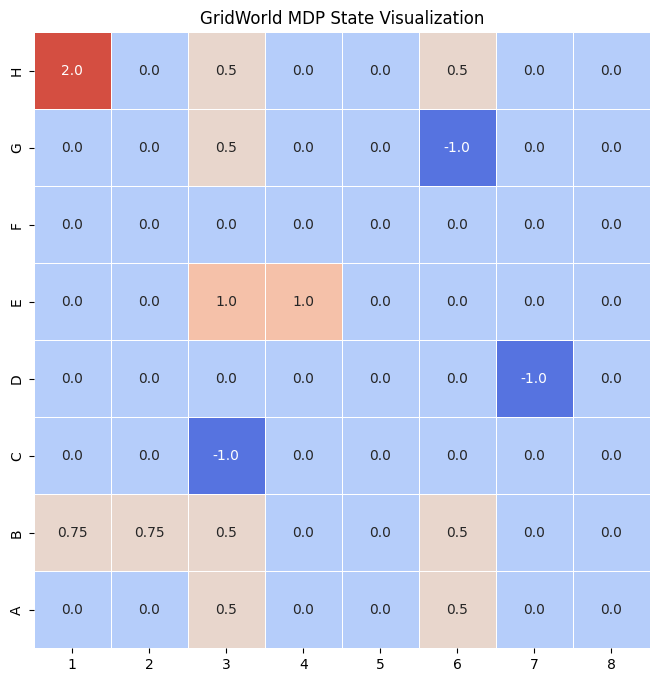

In [7]:
feature_counts = {'Treasure': 6, 'Bomb': 12, 'Mud': 10, 'Water': 8, 'Mountain': 6}
random_mdp = RandomGridWorld(feature_counts=feature_counts)
random_mdp.show_environment()  # Displays the grid with features.

### Question 4 and 5

#### Policy iteration implementation
Here, we'll create a class representing a policy iteration which do these 3 tasks:
    - **Evaluation** with evaluate method \
    - **Iteration** with iterate method \
    - **Improvement** with impove method

In [8]:
class PolicyIteration:
    def __init__(self, transition_probabilities, rewards, gamma=0.9, threshold=1e-10):
        """
        Initialize the policy iteration class.
        
        Args:
        transition_probabilities (numpy.ndarray): The transition probabilities with shape (nb_states, nb_actions, nb_states).
        rewards (numpy.ndarray): The rewards with shape (nb_states, nb_actions).
        gamma (float): The discount factor.
        threshold (float): The threshold for convergence.
        """
        self.T = transition_probabilities
        self.R = rewards
        self.gamma = gamma
        self.threshold = threshold
        self.nb_states, self.nb_actions = rewards.shape
        self.Policy = np.zeros(self.nb_states, dtype=int)
        self.Values = np.zeros(self.nb_states)

    def evaluate(self):
        """ Evaluate the current policy until convergence. """
        while True:
            R_pol = self.R[np.arange(self.nb_states), self.Policy]
            T_pol = self.T[np.arange(self.nb_states), self.Policy, :]
            Values_old = self.Values.copy()
            self.Values = R_pol + self.gamma * np.dot(T_pol, self.Values)
            delta = np.abs(self.Values - Values_old).max()
            if delta < self.threshold:
                break

    def improve(self):
        """ Improve the policy based on the evaluated values. """
        Q = self.R + self.gamma * np.dot(self.T, self.Values)
        new_policy = np.argmax(Q, axis=1)
        policy_stable = np.array_equal(self.Policy, new_policy)
        self.Policy = new_policy
        return policy_stable
    
    def iterate(self):
        """ Perform full policy iteration. """
        while True:
            self.evaluate()
            if self.improve():
                break
        return self.Values, self.Policy
    

# Question 5
# def give_a_set_of_actions(reward, timesteps, initial_state):
    

def simulate_tutor(self, start_state, num_steps):
        current_state = start_state
        state_action_pairs = []

        for _ in range(num_steps):
            if np.random.rand() < 0.95:
                action = self.Policy[current_state]
            else:
                action = np.random.choice(self.nb_actions)

            state_action_pairs.append((current_state, action))

            # Get next state based on transition probabilities for the chosen action
            probabilities = self.T[current_state, action]
            next_state = np.random.choice(self.nb_states, p=probabilities)

            current_state = next_state

        return state_action_pairs


#### Let's test the class